In [1]:
from spectral import *
import spectral
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import spectral as spy
from scipy.integrate import cumtrapz
from numpy import linalg as LA

img = spectral.open_image('D1_F12_H1_Cropped.hdr')
header ="C:/Users/Yaniv/PycharmProjects/project_stanley/D1_F12_H1_Cropped.hdr"
data = open_image(header)
my_cube = data.load().copy()

In [2]:
def visual(data, name,bands):  # Visualize the cube
    # Choose four different bands to display
    data = (255 / np.max(data.flatten())) * data
    bands = [bands[0], bands[1], bands[2], bands[3],bands[4],bands[5]]
    # Create a figure with subplots to display the band images
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
    # Display each band image in a subplot
    for band, ax in zip(bands, axes.flat):
        band_image = data[:, :, band]
        ax.imshow(band_image, cmap='gray')
        ax.set_title('Band {}'.format(band))
    plt.suptitle("{}".format(name))
    plt.show()
# bands = [1, 2, 3, 120]
# visual(my_cube, "Data",bands)

In [3]:
M = np.zeros(np.shape(my_cube))
for i in range(M.shape[-1]):
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    padded_matrix = np.pad(my_cube[:, :, i], (1, 1), mode='constant', constant_values=0)
    neighbor_count = convolve2d(np.ones_like(my_cube[:, :, i]), np.ones((3, 3)), mode='same')
    neighbor_sum = convolve2d(padded_matrix, kernel, mode='valid')
    M[:, :, i] = neighbor_sum / (neighbor_count - 1)

In [4]:
X_MINUS_M = np.subtract(my_cube, M)
arg_cov_n = X_MINUS_M.reshape(img.shape[0] * img.shape[1], img.shape[2])
phi_n = np.cov(arg_cov_n.transpose())  #Transpose- Python vs. Matlab
eigenvalues_n, eigenvectors_n = np.linalg.eig(phi_n)

In [5]:
white_cube = np.zeros(np.shape(my_cube))
my_matrix = np.diag(np.power(eigenvalues_n,-0.5))@eigenvectors_n.T
for i in range(np.shape(my_cube)[0]):
    for j in range(np.shape(my_cube)[1]):
        white_cube[i,j,:] = my_matrix@my_cube[i,j,:]

M_white = np.zeros(np.shape(white_cube)) #S'
for i in range(M.shape[-1]):
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    padded_matrix = np.pad(white_cube[:, :, i], (1, 1), mode='constant', constant_values=0)
    neighbor_count = convolve2d(np.ones_like(white_cube[:, :, i]), np.ones((3, 3)), mode='same')
    neighbor_sum = convolve2d(padded_matrix, kernel, mode='valid')
    M_white[:, :, i] = neighbor_sum / (neighbor_count - 1)

In [6]:
arg_cov_s = M_white.reshape(img.shape[0] * img.shape[1], img.shape[2])
phi_s = np.cov(arg_cov_s.transpose())  #Transpose- Python vs. Matlab
eigenvalues_s, eigenvectors_s = np.linalg.eig(phi_s)
sorted_indices_s = np.argsort(eigenvalues_s)[::-1]
sorted_eigenvalues_s = eigenvalues_s[sorted_indices_s]
sorted_eigenvectors_s = eigenvectors_s[:, sorted_indices_s] #(511, 511)

The 5 biggest eigenvalues of S are: [121.38893531  42.19729722  37.18158206  21.39216726   8.93372676]
The 5 smallest eigenvalues of S are: [0.09075213 0.09043934 0.0903537  0.08965214 0.08948716]
The sums ratio: 0.7937631702298927


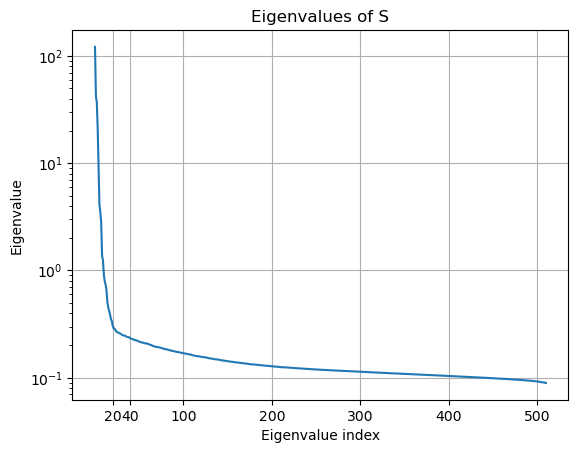

In [7]:
print("The 5 biggest eigenvalues of S are:", sorted_eigenvalues_s[0:5])
print("The 5 smallest eigenvalues of S are:", sorted_eigenvalues_s[-5:])
print("The sums ratio:", np.sum(sorted_eigenvalues_s[0:21])/np.sum(sorted_eigenvalues_s))
plt.plot(sorted_eigenvalues_s)
plt.title("Eigenvalues of S")
plt.xlabel("Eigenvalue index")
x_ticks = [20,40]+list(np.linspace(100, 500, 5))
plt.xticks(x_ticks)
plt.ylabel("Eigenvalue")
plt.grid()
plt.yscale('log')
plt.title("Eigenvalues of S")
plt.show()

In [8]:
final_cube = np.zeros(np.shape(my_cube))
for i in range(np.shape(my_cube)[0]):
    for j in range(np.shape(my_cube)[1]):
        final_cube[i,j,:] = sorted_eigenvectors_s.T.real@white_cube[i,j,:]

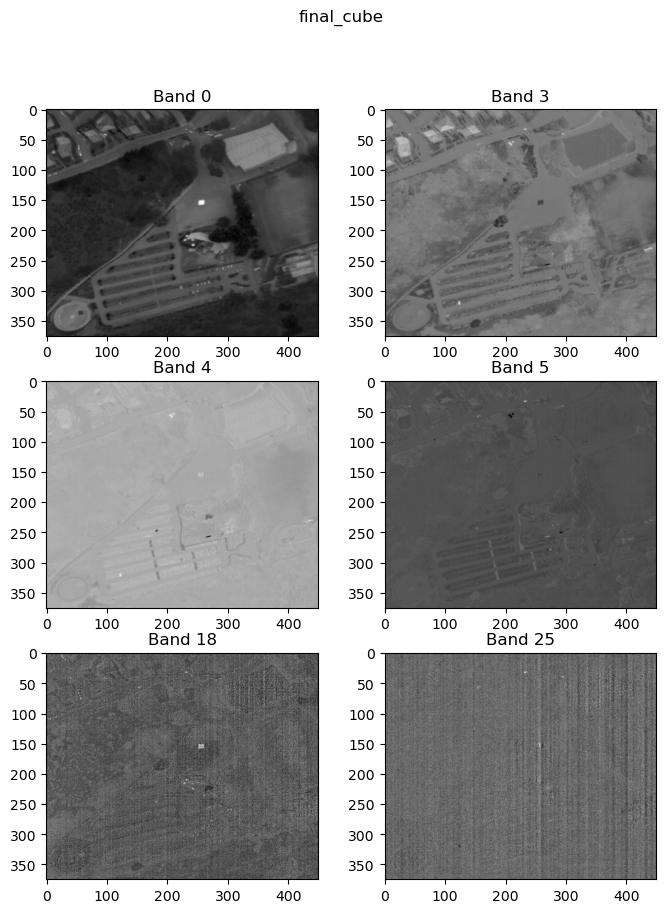

In [9]:
bands = [0,3,4,5,18,25]
visual(final_cube, "final_cube",bands)

The first channel where the std is smaller than 1.1 is: 18


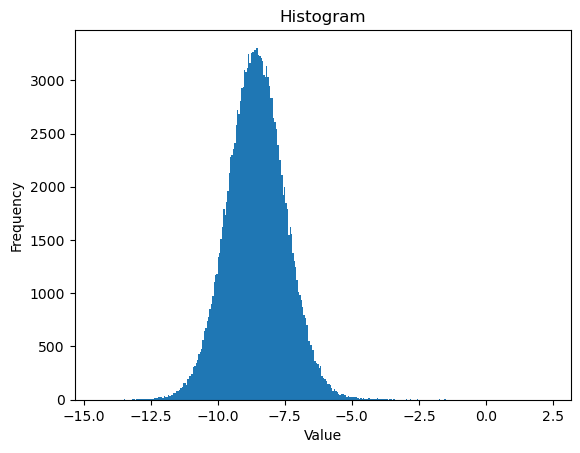

the ratio between the histogram of this channel to the histogram of the last channek is: 1.3482590396253493


In [10]:
def plot_histogram(matrix):
    flattened_matrix = matrix.flatten()  # Flatten the matrix into a 1-D array
    plt.hist(flattened_matrix, bins='auto')  # Plot the histogram
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.show()

list_of_std = [np.std(final_cube[:,:,i].flatten()) for i in range(np.shape(final_cube)[2])]
print("The first channel where the std is smaller than 1.1 is:", np.nonzero(np.array(list_of_std) < 1.1)[0][0])
k = np.nonzero(np.array(list_of_std) < 1.1)[0][0]
plot_histogram(final_cube[:,:,np.nonzero(np.array(list_of_std) < 1.1)[0][0]])
hist0, bin0 =  np.histogram(final_cube[:,:,k])
hist_f, bin_f = np.histogram(final_cube[:,:,-1])
print("the ratio between the histogram of this channel to the histogram of the last channek is:", np.trapz(hist0, bin0[:-1])/np.trapz(hist_f, bin_f[:-1]))


Part 2:

In [75]:
number_of_bands = 300 #21 for good performance, 300 for equal performance
new_cube = final_cube[:, :, :number_of_bands]
p = 0.25 #TODO just note that it big for RX filter
t = my_cube[2, 4, :]
t_inv_phi = np.dot(t, LA.inv(phi_n))
t_inv_phi_t = np.dot(t_inv_phi, t)

M_new = np.zeros(np.shape(new_cube))
for i in range(M_new.shape[-1]):
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    padded_matrix = np.pad(new_cube[:, :, i], (1, 1), mode='constant', constant_values=0)
    neighbor_count = convolve2d(np.ones_like(new_cube[:, :, i]), np.ones((3, 3)), mode='same')
    neighbor_sum = convolve2d(padded_matrix, kernel, mode='valid')
    M_new[:, :, i] = neighbor_sum / (neighbor_count - 1)

t_new = new_cube[2, 4, :]
X_MINUS_M_new = np.subtract(new_cube, M_new)
arg_cov_new = X_MINUS_M_new.reshape(np.shape(M_new)[0] * np.shape(M_new)[1], np.shape(M_new)[2])
phi_new = np.cov(arg_cov_new.transpose())  # Transpose- Python vs. Matlab
t_inv_phi_new = np.dot(t_new, LA.inv(phi_new))
t_inv_phi_t_new = np.dot(t_inv_phi_new, t_new)

In [ ]:
# A = LA.inv(phi_n)
# A_new = LA.inv(phi_new)
# i,j = 34,68
# print(X_MINUS_M[i, j, :]@A@ X_MINUS_M[i, j, :])
# print(X_MINUS_M[i, j, :]@A@ X_MINUS_M[i, j, :])

In [73]:
# MF_NT = np.zeros((img.shape[0], img.shape[1]))
# MF_WT = np.zeros((img.shape[0], img.shape[1]))
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         MF_NT[i, j] = np.dot(t_inv_phi, (my_cube[i, j, :] - M[i, j, :]))
#         MF_WT[i, j] = np.dot(t_inv_phi, (my_cube[i, j, :] - M[i, j, :] + p * t))

A = LA.inv(phi_n)
MF_NT_RX = np.zeros((img.shape[0], img.shape[1]))
MF_WT_RX = np.zeros((img.shape[0], img.shape[1]))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        MF_NT_RX[i, j] = X_MINUS_M[i, j, :]@A@ X_MINUS_M[i, j, :]#pow(np.dot(t_inv_phi, (my_cube[i, j, :] - M[i, j, :])),2)/(t_inv_phi_t*np.dot(np.dot((my_cube[i, j, :] - M[i, j, :]), A), (my_cube[i, j, :] - M[i, j, :])))
        MF_WT_RX[i, j] = (X_MINUS_M[i, j, :]+p*t)@A@(X_MINUS_M[i, j, :]+p*t)#pow(np.dot(t_inv_phi, (my_cube[i, j, :] - M[i, j, :] + p * t)),2)/(t_inv_phi_t*np.dot(np.dot((my_cube[i, j, :] - M[i, j, :] + p * t), A), (my_cube[i, j, :] - M[i, j, :] + p * t)))

NT_val, NT_bins = np.histogram(MF_NT_RX, bins=100)#np.histogram(MF_NT_RX, bins=100)
WT_val, WT_bins = np.histogram(MF_WT_RX, bins=100)#np.histogram(MF_WT_RX, bins=100)

In [76]:
Pd = 1 - (np.cumsum(WT_val) / np.sum(WT_val))
Pfa = 1 - (np.cumsum(NT_val) / np.sum(NT_val))

# MF_NT_new = np.zeros((img.shape[0], img.shape[1]))
# MF_WT_new = np.zeros((img.shape[0], img.shape[1]))
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         MF_NT_new[i, j] = np.dot(t_inv_phi_new, (new_cube[i, j, :] - M_new[i, j, :]))
#         MF_WT_new[i, j] = np.dot(t_inv_phi_new, (new_cube[i, j, :] - M_new[i, j, :] + p * t_new))

A_new = LA.inv(phi_new)
MF_NT_RX_new = np.zeros((img.shape[0], img.shape[1]))
MF_WT_RX_new = np.zeros((img.shape[0], img.shape[1]))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        MF_NT_RX_new[i, j] = X_MINUS_M_new[i, j, :]@A_new@ X_MINUS_M_new[i, j, :]#pow(np.dot(t_inv_phi_new, (new_cube[i, j, :] - M_new[i, j, :])),2)/(t_inv_phi_t_new*np.dot(np.dot((new_cube[i, j, :] - M_new[i, j, :]), A_new), (new_cube[i, j, :] - M_new[i, j, :])))#X_MINUS_M[i, j, :]@A@ X_MINUS_M[i, j, :]
        MF_WT_RX_new[i, j] = (X_MINUS_M_new[i, j, :]+p*t_new)@A_new@(X_MINUS_M_new[i, j, :]+p*t_new)#pow(np.dot(t_inv_phi_new, (new_cube[i, j, :] - M_new[i, j, :] + p * t_new)),2)/(t_inv_phi_t_new*np.dot(np.dot((new_cube[i, j, :] - M_new[i, j, :] + p * t_new), A_new), (new_cube[i, j, :] - M_new[i, j, :] + p * t_new)))#(X_MINUS_M[i, j, :]+p*t)@A@(X_MINUS_M[i, j, :]+p*t)

NT_val_new, NT_bins_new = np.histogram(MF_NT_RX_new, bins=100)
WT_val_new, WT_bins_new = np.histogram(MF_WT_RX_new, bins=100)
Pd_new = 1 - (np.cumsum(WT_val_new) / np.sum(
    WT_val_new))  # 1-((cumtrapz(WT_val, WT_bins[:-1]))/(cumtrapz(WT_val, WT_bins[:-1])[-1]))
Pfa_new = 1 - (np.cumsum(NT_val_new) / np.sum(
    NT_val_new))  # 1-((cumtrapz(NT_val, NT_bins[:-1]))/(cumtrapz(NT_val, NT_bins[:-1])[-1]))

number of bands: 300


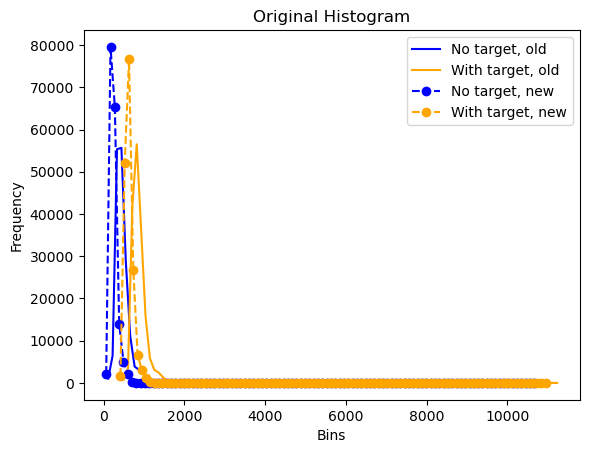

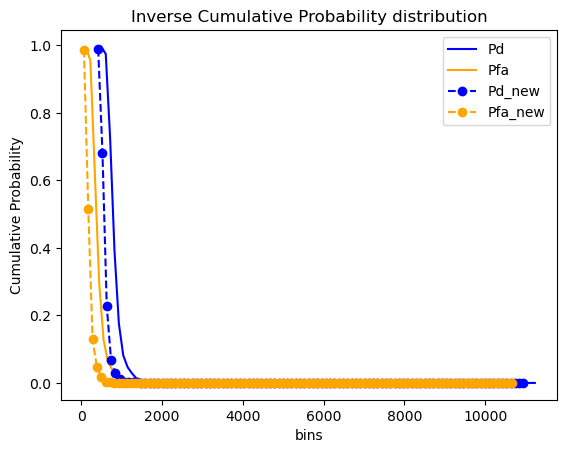

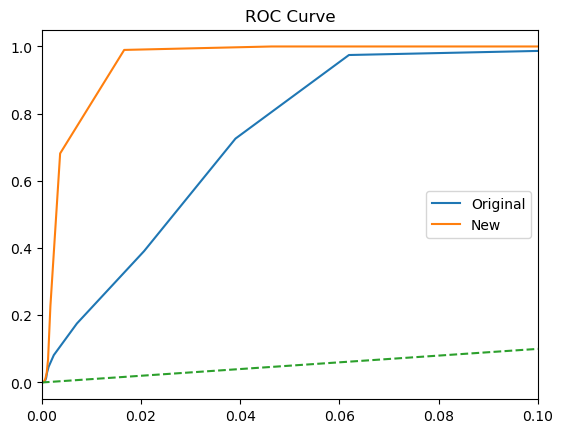

Old performance, using 'area test':
th= 0.001: 0.0037377734134560257
th= 0.01: 0.18324628927904257
th= 0.1: 0.6445152943989604
New performance, using 'area test':
th= 0.001: 0.011299664647138581
th= 0.01: 0.5361809660648934
th= 0.1: 0.8169132596231314


In [77]:
print("number of bands:", number_of_bands)

plt.plot(NT_bins[:-1], NT_val,color='blue', label='No target, old')
plt.plot(WT_bins[:-1], WT_val,color='orange', label='With target, old')
plt.plot(NT_bins_new[:-1], NT_val_new,color='blue', label='No target, new',marker="o",linestyle='--')
plt.plot(WT_bins_new[:-1], WT_val_new,color='orange' ,label='With target, new',marker="o",linestyle='--')
plt.title('Original Histogram')
plt.xlabel("Bins")
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.plot(WT_bins[:-1], Pd,color='blue', label="Pd")
plt.plot(NT_bins[:-1], Pfa,color='orange', label="Pfa")
plt.plot(WT_bins_new[:-1],Pd_new,color='blue',  marker="o",label="Pd_new",linestyle='--')
plt.plot(NT_bins_new[:-1],Pfa_new,color='orange',  marker="o",label="Pfa_new",linestyle='--')
plt.xlabel('bins')
plt.ylabel('Cumulative Probability')
plt.title('Inverse Cumulative Probability distribution')
plt.legend()
plt.show()

th = 0.1
index = max(100 - np.argmax(WT_bins > NT_bins[-1]), np.argmax(NT_bins > WT_bins[0]))
Pd = np.pad(Pd, (index, 0), mode='constant', constant_values=(1, 1))
Pfa = np.pad(Pfa, (0, index), mode='constant', constant_values=(0, 0))
Pd = np.flip(Pd)
Pfa = np.flip(Pfa)

index_new = max(100 - np.argmax(WT_bins_new > NT_bins_new[-1]), np.argmax(NT_bins_new > WT_bins_new[0]))
Pd_new = np.pad(Pd_new, (index_new, 0), mode='constant', constant_values=(1, 1))
Pfa_new = np.pad(Pfa_new, (0, index_new), mode='constant', constant_values=(0, 0))
Pd_new = np.flip(Pd_new)
Pfa_new = np.flip(Pfa_new)

plt.title('ROC Curve')
plt.plot(Pfa, Pd, label='Original')
plt.plot(Pfa_new, Pd_new,label='New')
plt.plot([0, th], [0, th], '--')
plt.xlim(0, th)
plt.legend(['Original', 'New'])
plt.show()

from scipy.integrate import trapz
def area(th):
    cond = np.where(Pfa > th)[0][0]
    Pd_mask = Pd.copy()
    Pd_mask[cond:] = 0
    A = trapz(Pd_mask, Pfa)
    return (A - 0.5 * pow(th, 2)) / (th - 0.5 * pow(th, 2))
print("Old performance, using 'area test':")
print("th= 0.001:", area(0.001))
print("th= 0.01:", area(0.01))
print("th= 0.1:", area(0.1))

def area_new(th):
    cond_new = np.where(Pfa_new > th)[0][0]
    Pd_mask_new = Pd_new.copy()
    Pd_mask_new[cond_new:] = 0
    A_new = trapz(Pd_mask_new, Pfa_new)
    return (A_new - 0.5 * pow(th, 2)) / (th - 0.5 * pow(th, 2))
print("New performance, using 'area test':")
print("th= 0.001:", area_new(0.001))
print("th= 0.01:", area_new(0.01))
print("th= 0.1:", area_new(0.1))